<a href="https://colab.research.google.com/github/Khushm/SRIP-IITGN-2022/blob/main/Neural%20Network%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks
Neural networks consists of neurons, connections between these neurons called weights and some biases connected to each neuron. We distinguish between input, hidden and output layers, where we hope each layer helps us towards solving our problem.

It is designed to recognize patterns in complex data, and often performs the best when recognizing patterns in audio, images or video.

In [11]:
# importing the required jax numpy library for calculations
import jax.tools.colab_tpu
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from sklearn.metrics import mean_squared_error
import numpy as np
import jax
from jax import jit, vmap, pmap, grad, value_and_grad, random

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# importing matplotlib for visualization
import matplotlib.pyplot as plt

## Hyperparameters

In [12]:
layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10
mnist_img_size = (28, 28)

seed = 0
key = jax.random.PRNGKey(seed)

In [13]:
# Function to initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(layer_sizes, key, step_size=step_size):
  params = []
  keys = random.split(key, num=len(layer_sizes)-1)
  
  # loop to randomly initialize weights and biases
  # for a dense neural network layer
  for in_width, out_width, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
    weight_key, bias_key = jax.random.split(key) # Bias is used to approximate where the value of the new neuron starts to be meaningful
    params.append([
          step_size * jax.random.normal(weight_key, shape=(out_width, in_width)),
          step_size * jax.random.normal(bias_key, shape=(out_width,))
          ])
  return params


params = init_network_params(layer_sizes, key, step_size)
print(jax.tree_map(lambda x: x.shape, params))

[[(512, 784), (512,)], [(512, 512), (512,)], [(10, 512), (10,)]]


## Forward pass
To move forward through the network, called a forward pass, we iteratively use a formula to calculate each neuron in the next layer.

We have something called mini-batches(batched_predict), where we average the gradient of some number of defined observation per mini-batch, and then we have the basic neural network setup.

In [18]:
# Activation function for the neurons
# ReLU stands for Rectified Linear Unit.
# The main advantage is simple and sparsity
def relu(x):
  return jnp.maximum(0, x)


# predict function produces result of the network prediction for each sample
# This function is very similar to feed forward,
# First we find neurons' values for hidden layer, then for output layer
def predict(params, image):
   hidden_layers = params[:-1]

   activations = image
   for w, b in hidden_layers:
     outputs = jnp.dot(w, activations) + b
     activations = relu(outputs)

   final_w, final_b = params[-1]
   logits = jnp.dot(final_w, activations) + final_b
   return logits - logsumexp(logits) 


x = np.random.randn(np.prod(mnist_img_size))
random_flattened_images = np.random.randn(16, np.prod(mnist_img_size))

# use JAX’s vmap function to automatically handle mini-batches, 
# with no performance penalty
batched_predict = vmap(predict, in_axes=(None,0))
predictions = batched_predict(params, random_flattened_images)
print(predictions.shape)

(16, 10)


At this point, we have all the ingredients we need to define our neural network and train it. 

## Data Loading
Trying to classify digits from 0 - 9 using a dataset called MNIST. This data set consists of 70,000 images that are 28 by 28 pixels each. The data set contains one label for each image that specifies the digit and there are 10 classes/labels.


In [19]:
def custom_transform(x):
    return jnp.ravel(jnp.array(x, dtype=jnp.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = jnp.array(transposed_data[1])
    imgs = jnp.stack(transposed_data[0])

    return imgs, labels


train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int32


## Training and Utility, loss functions
Defining the layers in an exact way. 
1. **Input layer**: In this layer, I input my data set consisting of 28x28 images and flatten these images into one array with 28×28=78428×28=784 elements. This means that the input layer will have 784 nodes.

2. Hidden layer 1: In this layer, I reduce the number of nodes from 784 in the input layer to 512 nodes.

3. Hidden layer 2: In this layer, I decide to go with 256 nodes, from the 512 nodes in the first hidden layer. This is no new challenge because I've already reduced the number in the first layer.

4. Output layer: In this layer, I reduce the 256 nodes to a total of 10 nodes so that I can evaluate the nodes against the label. This label is received in the form of an array with 10 elements, where one of the elements is 1 while the rest are 0.

The specific number of nodes chosen were at random, although decreasing to avoid overfitting.

Epoch 0, train acc = 0.9142166972160339 test acc = 0.9169999957084656 loss = 0.054982125759124756
Epoch 1, train acc = 0.9355666637420654 test acc = 0.9348999857902527 loss = 0.026666440069675446
Epoch 2, train acc = 0.9470333456993103 test acc = 0.9444999694824219 loss = 0.021401291713118553
Epoch 3, train acc = 0.9523833394050598 test acc = 0.9501000046730042 loss = 0.018027668818831444
Epoch 4, train acc = 0.9585666656494141 test acc = 0.9532999992370605 loss = 0.015658993273973465
Epoch 5, train acc = 0.9633833169937134 test acc = 0.9589999914169312 loss = 0.013738561421632767
Epoch 6, train acc = 0.9694333672523499 test acc = 0.9627999663352966 loss = 0.012361864559352398
Epoch 7, train acc = 0.9718000292778015 test acc = 0.9643999934196472 loss = 0.011097724549472332
Epoch 8, train acc = 0.9749333262443542 test acc = 0.9670999646186829 loss = 0.010092552751302719
Epoch 9, train acc = 0.9764666557312012 test acc = 0.967199981212616 loss = 0.009215205907821655


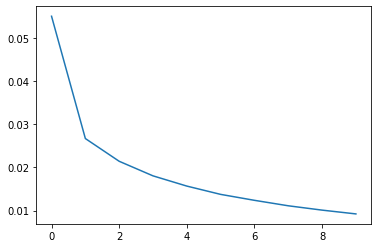

In [25]:
def loss(params, images, gt_lbls):
    predictions = batched_predict(params, images)
    return -jnp.mean(predictions * gt_lbls)


def accuracy(params, images, target_class):
    predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

# use jit to speed up everything
@jit
def update(params, images, gt_lbls, lr=step_size):
    # use grad to take the derivative of the loss 
    # with respect to the neural network parameters
    loss_value, grads = value_and_grad(loss)(params, images, gt_lbls)
    return loss_value, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Training
# Passing in an array of sizes that defines the number of activations for each layer and key
params = init_network_params([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key, step_size)

loss_values = []
# There are two main loops in the training function. 
# One loop for the number of epochs, which is the number of times to run the entire data set,
# and a second loop for running through each observation one by one.
for epoch in range(num_epochs):
    losses = []
    for cnt, (imgs, lbls) in enumerate(train_loader):
        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        loss, params = update(params, imgs, gt_labels)    
        losses.append(loss)
    loss_values.append(jnp.average(losses))
    print(f'Epoch {epoch}, train acc = {accuracy(params, train_images, train_lbls)} test acc = {accuracy(params, test_images, test_lbls)} loss = {loss_values[epoch]}')
plt.plot(loss_values)
plt.show()

## Testing

(28, 28)
prediction:  9
actual:  9


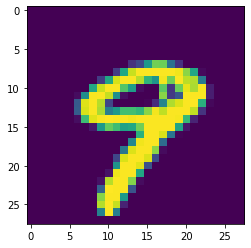

In [26]:
imgs, lbls = next(iter(test_loader))
img = imgs[9].reshape(mnist_img_size)
gt_lbl = lbls[9]
print(img.shape)


pred = jnp.argmax(predict(params, np.ravel(img)))
print('prediction: ', pred)
print('actual: ', gt_lbl)

plt.imshow(img); plt.show()

## Conclusion
We’ve used the whole of the JAX API: grad for derivatives, jit for speedups and vmap for auto-vectorization. We used NumPy to specify all of our computation, and borrowed the great data loaders from torch/datasets.

The most important thing to remember is that the neural network is simply trained to reduce output error by modifying weights and biases. Feedforward and backpropagation are used in the training process. Backpropagation adjusts weights and biases to reduce the output error, i.e. the difference between predicted and true values, whereas feedforward predicts output.